# 25-D Correlated Normal

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# Python 3 compatability
from __future__ import division, print_function
from six.moves import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
np.random.seed(21)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems (with or without the use of gradients). Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems using a 25-D correlated multivariate normal distribution.

In [4]:
ndim = 25  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.4  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -5. and 5. in each variable."""
    return 5. * (2. * u - 1.)

# gradient of log-likelihood *with respect to u*
def gradient(x):
    """Multivariate normal log-likelihood gradient."""
    dlnl_dv = -np.dot(Cinv, x)  # standard gradient
    jac = np.diag(np.full_like(x, 10.))  # Jacobian
    return np.dot(jac, dlnl_dv)  # transformed gradient

# ln(evidence)
lnz_truth = -ndim * np.log(10. * 0.999999426697)
print(lnz_truth)

-57.56461299227203


Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                nlive=500, bound='single', 
                                sample='slice', slices=5)
sampler.run_nested(dlogz=0.01)
res = sampler.results

20681it [39:00,  8.84it/s, +500 | bound: 218 | nc: 1 | ncall: 12343288 | eff(%):  0.172 | loglstar:   -inf < -20.702 <    inf | logz: -57.419 +/-  0.233 | dlogz:  0.000 >  0.010]


In [6]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single', 
                                sample='rslice', slices=25)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

20612it [05:47, 59.38it/s, +500 | bound: 99 | nc: 1 | ncall: 2488608 | eff(%):  0.849 | loglstar:   -inf < -20.961 <    inf | logz: -57.539 +/-  0.233 | dlogz:  0.000 >  0.010]


In [7]:
# hamiltonian slice sampling ('hslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single',
                                sample='hslice', slices=5,
                                gradient=gradient)
sampler.run_nested(dlogz=0.01)
res3 = sampler.results

20876it [21:27, 16.21it/s, +500 | bound: 211 | nc: 1 | ncall: 13297937 | eff(%):  0.161 | loglstar:   -inf < -20.598 <    inf | logz: -57.705 +/-  0.233 | dlogz:  0.000 >  0.010]


Now let's see how we do.

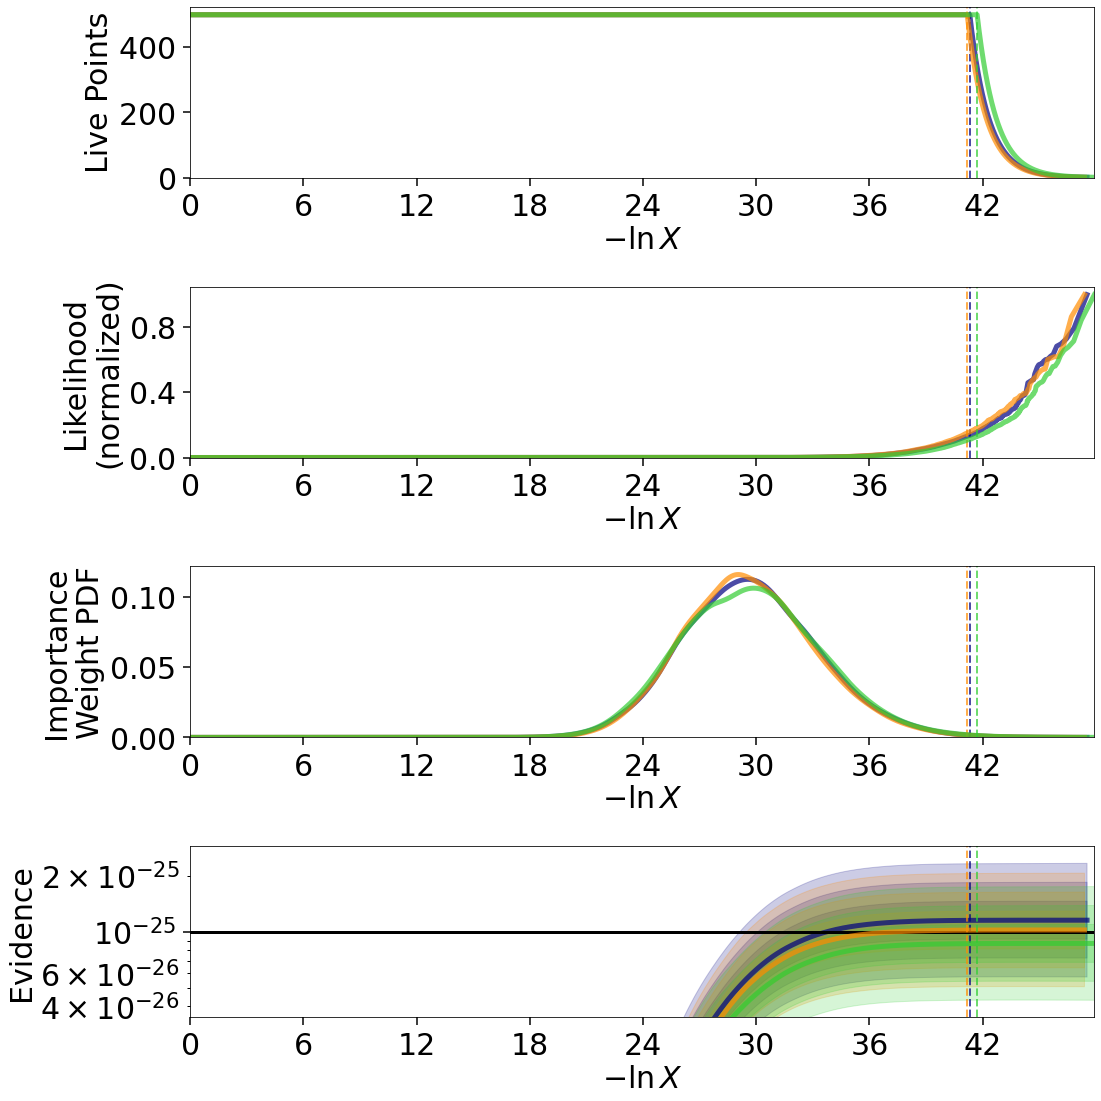

In [8]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, color='navy', logplot=True,
                           lnz_truth=lnz_truth, truth_color='black')
fig, axes = dyplot.runplot(res2, color='darkorange', logplot=True, fig=(fig, axes))
fig, axes = dyplot.runplot(res3, color='limegreen', logplot=True, fig=(fig, axes))
fig.tight_layout()

In [9]:
from dynesty import utils as dyfunc

print('Mean:')
print('slice:', dyfunc.mean_and_cov(res.samples, 
                                    np.exp(res.logwt-res.logz[-1]))[0])
print('rslice:', dyfunc.mean_and_cov(res2.samples, 
                                     np.exp(res2.logwt-res2.logz[-1]))[0])
print('hslice:', dyfunc.mean_and_cov(res3.samples, 
                                     np.exp(res3.logwt-res3.logz[-1]))[0])

print('\nVariance:')
print('slice:', np.diagonal(dyfunc.mean_and_cov(res.samples, 
                                                np.exp(res.logwt-res.logz[-1]))[1]))
print('rslice:', np.diagonal(dyfunc.mean_and_cov(res2.samples, 
                                                 np.exp(res2.logwt-res2.logz[-1]))[1]))
print('hslice:', np.diagonal(dyfunc.mean_and_cov(res3.samples, 
                                                 np.exp(res3.logwt-res3.logz[-1]))[1]))

Mean:
slice: [ 0.00989191  0.01951718  0.00600637  0.02571864 -0.00831929  0.0147791
  0.02102184  0.00944134  0.02247861  0.01757231  0.0018746   0.02353766
  0.02328337  0.0182514  -0.00324114  0.00530437  0.01586198  0.01188948
  0.00876995 -0.0001796   0.01565495  0.00703576  0.02124338  0.0101939
  0.00915269]
rslice: [-0.0269235  -0.03426991 -0.01493866  0.00702195 -0.02149684  0.01409468
  0.02366878  0.00340017 -0.02742496  0.00174066 -0.02119775 -0.03099954
 -0.04177341  0.01471728 -0.01289293 -0.02241176 -0.0496216  -0.01925752
 -0.00914532 -0.01887279 -0.02526213 -0.01424214 -0.00975135 -0.021164
 -0.01451319]
hslice: [-0.00400148  0.00564449  0.01042    -0.00348471  0.01153019  0.00488365
  0.00338993  0.00742683  0.00761398  0.00597423  0.00443318 -0.01308105
 -0.00671983  0.00025253  0.01411281  0.02028615 -0.0113256  -0.0067292
  0.00071469 -0.01237027  0.01053285  0.02476801  0.00950782  0.01145694
  0.01416207]

Variance:
slice: [0.98952051 0.99599272 0.9857151  0.9933